# Depth findings in Movies

## II. User profiles

In this section, we try to build user profiles, looking for user with high participation on rankings. We want to discover the preferences of people, according genres, description of movies and key-words. 

### Importing Data

Importing relevant packages:

In [1]:
import re
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Importing movies and ratings datasets:

In [2]:
df_movies = pd.read_csv('../Data/interim/movies/movies.csv')

In [3]:
df_movies.rename(columns = {'Unnamed: 0': 'counter'}, inplace=True)

In [4]:
df_movies.head(2)

,counter,adult,belongs_to_collection,genres,id,original_language,overview,popularity,production_companies,production_countries,...,Foreign,History,Horror,Music,Mystery,Romance,Thriller,War,Western,key_list
0,0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...","[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,en,"Led by Woody, Andy's toys live happily in his ...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"['jealousy', 'toy', 'boy', 'friendship', 'frie..."
1,1,False,NaN,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,en,When siblings Judy and Peter discover an encha...,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"['disappearance', 'recluse']"


In [5]:
df_ratings = pd.read_csv('../Data/raw/movies/the-movies-dataset/ratings.csv')

In [6]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


As we can note, the rating dataset contains `userId`, `movieId` and `rating`. Grouping by users, we could determine which users are actively voting movies and they could bring us more information to generate profiles: 

In [7]:
df_users = df_ratings.groupby('userId').count().movieId

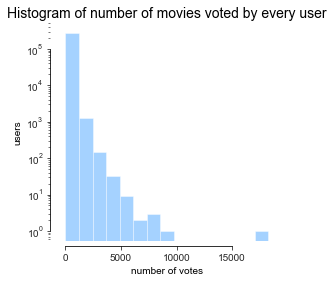

In [8]:
f, ax = plt.subplots(figsize=(4, 4))
_ = sns.set_style("white")
ax = sns.distplot(df_users, kde=False, bins=15, color='dodgerblue')
ax.set_yscale('log')
_ = plt.xlabel('number of votes', fontsize=10)
_ = plt.ylabel('users', fontsize=10)
_ = plt.title('Histogram of number of movies voted by every user', fontsize=14)
_ = sns.despine(offset=5, trim=True)

According to the Figure, almost all people vote 1-5000 movies. Inspecting percentiles, we could get values to filter users:

In [9]:
print('Percentiles 80 = {}'.format(np.percentile(df_users.values, 80)) + '\nPercentile 95 = {}'.format(np.percentile(df_users.values, 95)))

Percentiles 80 = 119.0
Percentile 95 = 398.0


80% of users had voted less than 120 movies and 95% of people sum up less than 400 movies. Therefore, the users with frecuencies lower than 120 movies and upper than 400 are filtered:

In [10]:
users_idx = df_users.where((df_users.values > 120) & (df_users.values < 400)).dropna()
print(len(users_idx))

40301


Filtering the users from the ratings dataFrame and then merging with the movies dataset:

In [11]:
df_ratings_filter = df_ratings[df_ratings['userId'].isin(users_idx.index.tolist())]

In [12]:
df_movies_rating = df_movies.merge(df_ratings_filter, left_on='id', right_on='movieId')

In [13]:
df_movies_rating_group = df_movies_rating.groupby('userId').count()
df_movies_rating_group.head()

,counter,adult,belongs_to_collection,genres,id,original_language,overview,popularity,production_companies,production_countries,...,Music,Mystery,Romance,Thriller,War,Western,key_list,movieId,rating,timestamp
userId,,,,,,,,,,,,,,,,,,,,,
11,67,67,17,67,67,67,67,67,67,67,...,3,8,7,17,2,1,67,67,67,67
12,136,136,28,136,136,136,135,136,136,136,...,3,14,26,32,1,3,136,136,136,136
15,77,77,13,77,77,77,76,77,77,77,...,4,7,11,23,1,0,77,77,77,77
16,54,54,8,54,54,54,54,54,54,54,...,1,3,10,15,2,5,54,54,54,54
20,86,86,18,86,86,86,86,86,86,86,...,0,8,11,19,5,2,86,86,86,86


After merging datasets, we loss information from users and movies. Again, we filter users using the previously got percentiles 85 and 90:

In [14]:
users_idx_filter = df_movies_rating_group.where((df_movies_rating_group.counter > 120) & (df_movies_rating_group.counter < 400)).dropna()

In [15]:
len(users_idx_filter)

9246

In [16]:
df_user_sample = users_idx_filter.sample(frac=0.1, random_state=0)

In [17]:
df_movies_rating_filter = df_movies_rating[df_movies_rating['userId'].isin(df_user_sample.index.tolist())]

Building a copy of dataframe:

In [18]:
df_mov_rating = df_movies_rating_filter.copy()

Selecting columns for the analysis:

In [19]:
df_mov_rating = df_mov_rating.loc[:, ['userId', 'movieId', 'title', 
                       'overview', 'spoken_languages', 
                       'rating', 'genres_list', 'key_list', 
                       'vote_count', 'vote_average',
                       'runtime', 'release_date']]

In [20]:
df_mov_rating.head(2)

,userId,movieId,title,overview,spoken_languages,rating,genres_list,key_list,vote_count,vote_average,runtime,release_date
29,81267,862,Toy Story,"Led by Woody, Andy's toys live happily in his ...","[{'iso_639_1': 'en', 'name': 'English'}]",4.0,"['Animation', 'Comedy', 'Family']","['jealousy', 'toy', 'boy', 'friendship', 'frie...",5415.0,7.7,81.0,1995-10-30
44,108287,862,Toy Story,"Led by Woody, Andy's toys live happily in his ...","[{'iso_639_1': 'en', 'name': 'English'}]",4.0,"['Animation', 'Comedy', 'Family']","['jealousy', 'toy', 'boy', 'friendship', 'frie...",5415.0,7.7,81.0,1995-10-30


Multi-indexing by users and movies:

In [21]:
df_user = df_mov_rating.set_index(['userId', 'movieId']).sort_values('userId')
#df_user.reset_index()

In [22]:
df_user.head(2)

title  \
userId movieId                       
321    2762     Young and Innocent   
       920                    Cars   

                                                         overview  \
userId movieId                                                      
321    2762     Derrick De Marney finds himself in a 39 Steps ...   
       920      Lightning McQueen, a hotshot rookie race car d...   

                                                 spoken_languages  rating  \
userId movieId                                                              
321    2762              [{'iso_639_1': 'en', 'name': 'English'}]     4.0   
       920      [{'iso_639_1': 'en', 'name': 'English'}, {'iso...     2.0   

                                                   genres_list  \
userId movieId                                                   
321    2762                                 ['Drama', 'Crime']   
       920      ['Animation', 'Adventure', 'Comedy', 'Family']   

                                                         key_list  vote_count  \
userId movieId                                                                  
321    2762                                ['murder', 'suspense']        42.0   
       920      ['auto', 'wrecker', 'porsche', 'retirement', '...      3991.0   

                vote_average  runtime release_date  
userId movieId                                      
321    2762              6.8     83.0   1937-11-01  
       920               6.6    117.0   2006-06-08

Build a dictionary of userId, genres and genres (to count the number of movies depending on the genres and how the user qualify every genre).

In [23]:
genres = []
rating = []
userId = []
movieId = []
vote_average = []

for i in range(df_user.shape[0]):
    a, b = df_user.index[i][0], df_user.index[i][1]
    try:
        df_user.genres_list[a, b].split(',')
    except:
        continue
    for g in df_user.genres_list[a, b].split(','):
        g = g.replace('[','').replace(']','').replace("'", "").replace(" ", "")
        
        userId.append(a)
        movieId.append(b)
        genres.append(g)
        rating.append(df_user.rating[a, b])
        vote_average.append(df_user.vote_average[a, b])
        
df_users_profiles = pd.DataFrame({'userId': userId, 
                                  'movieId': movieId, 
                                  'genre': genres, 
                                  'rating': rating, 
                                  'vote_average': vote_average})       

/Users/daniela/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


Checking genres:

In [24]:
df_users_profiles.genre.unique()

array(['Drama', 'Crime', 'Animation', 'Adventure', 'Comedy', 'Family',
       'Foreign', 'Action', 'Thriller', 'Horror', 'Romance', 'Mystery',
       'Western', 'Documentary', 'War', 'History', 'Fantasy', 'Music'],
      dtype=object)

In [25]:
#df_users_profiles.userId.unique()

Now, we use the information about a specific user and his preferences in genres. To visualize that, boxplots of every genre are displayed below, showing the votes that this user did for movies belongs to every genre:

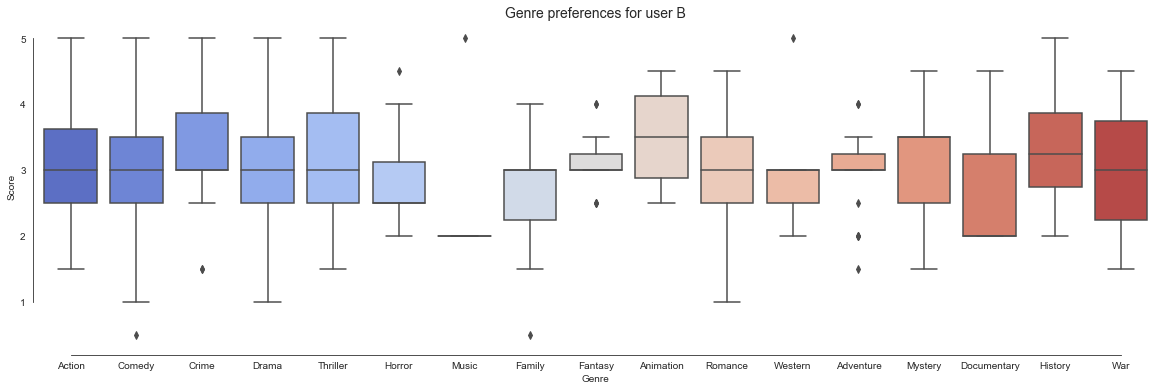

In [26]:
df_example = df_users_profiles[df_users_profiles.userId == 766]

f, ax = plt.subplots(figsize=(20, 6))
_ = sns.set_style("white")
_ = sns.boxplot(x='genre', y='rating', data=df_example, palette='coolwarm')
_ = plt.title('Genre preferences for user B', fontsize=14)
_ = plt.xlabel('Genre', fontsize=10)
_ = plt.ylabel('Score', fontsize=10)
_ = sns.despine(offset=5, trim=True)

The boxplots of average ratings from the movies in this sample is displayed below. As we can see, every genre offers a different distribution of scores:

In [27]:
def rescale(data):
    x = ((5 - 0)*(data - 0)/(10-0)) + 0
    return x

/Users/daniela/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


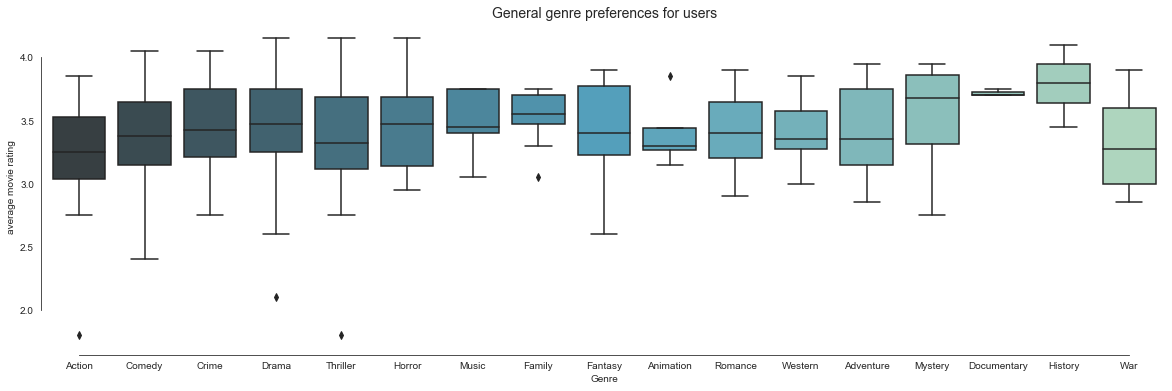

In [28]:
df_example['vote_average_rescaled'] = df_example.vote_average.apply(rescale)

f, ax = plt.subplots(figsize=(20, 6))
_ = sns.set_style("white")
_ = sns.boxplot(x='genre', y='vote_average_rescaled', data=df_example, palette='GnBu_d')
_ = plt.title('General genre preferences for users', fontsize=14)
_ = plt.xlabel('Genre', fontsize=10)
_ = plt.ylabel('average movie rating', fontsize=10)
_ = sns.despine(offset=5, trim=True)

In [29]:
df = df_users_profiles.groupby(['userId', 'genre']).rating.agg(['mean', 'std', 'min', 'max', 'count'])
df.head()

mean       std  min  max  count
userId genre                                         
321    Action     3.068966  0.820759  0.5  4.5     29
       Adventure  3.166667  0.841625  0.5  4.5     21
       Animation  3.000000  0.790569  2.0  4.0      5
       Comedy     3.043860  0.786497  0.5  4.5     57
       Crime      3.280000  0.693421  2.0  4.5     25

Algorithm to calculate rating of genres, adapted from https://math.stackexchange.com/questions/942738/algorithm-to-calculate-rating-based-on-multiple-reviews-using-both-review-score

In [30]:
from math import exp

def genres_ranking_by_user(df):
    """
    We adapt the algorithm describe on the link below to get a coefficient that represent
    the popularity of the genre for every user. This popularity depend on the number of movies 
    watched belongs to specific genre and the average rating for the same genre.
    """
    genres_ranking = []
    Q = 144
    #Q = 144
    for idx in df.index:
        p = df.loc[idx, 'mean']
        q = df.loc[idx, 'count']
        score = 5*p/10 + 5*(1 - exp(-q/Q))
        genres_ranking.append(score)
        
    return genres_ranking

In [31]:
df['ranking_genres'] = genres_ranking_by_user(df)

In [32]:
df.head(18)

mean       std  min  max  count  ranking_genres
userId genre                                                           
321    Action       3.068966  0.820759  0.5  4.5     29        2.446511
       Adventure    3.166667  0.841625  0.5  4.5     21        2.261825
       Animation    3.000000  0.790569  2.0  4.0      5        1.670632
       Comedy       3.043860  0.786497  0.5  4.5     57        3.156335
       Crime        3.280000  0.693421  2.0  4.5     25        2.436881
       Documentary  3.500000  0.547723  3.0  4.5      6        1.954053
       Drama        3.165000  0.855921  1.0  5.0    100        4.085741
       Family       2.750000  0.891883  1.5  5.0     12        1.774778
       Fantasy      3.208333  0.655686  2.0  4.5     12        2.003945
       Foreign      4.000000  0.707107  3.5  4.5      2        2.068964
       History      3.000000  0.845154  1.5  4.0      8        1.770203
       Horror       3.093750  1.003639  0.5  4.0     16        2.072678
       Music        2.857143  0.690066  1.5  3.5      7        1.665814
       Mystery      3.461538  0.320256  3.0  4.0     13        2.162382
       Romance      3.160000  0.850490  1.0  4.5     25        2.376881
       Thriller     3.324324  0.603419  1.5  5.0     37        2.795106
       War          2.833333  0.577350  2.5  3.5      3        1.519756
       Western      3.000000  0.500000  2.5  3.5      3        1.603089

/Users/daniela/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


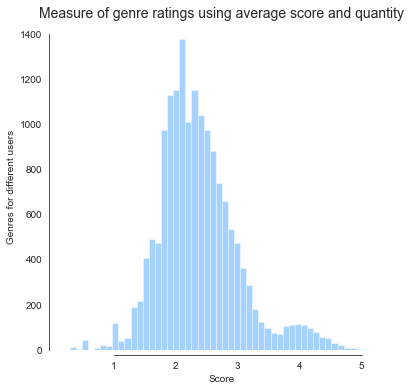

In [33]:
f, ax = plt.subplots(figsize=(6, 6))
_ = sns.set_style("white")
_ = sns.distplot(df['ranking_genres'], color='dodgerblue', kde=False)
_ = plt.title('Measure of genre ratings using average score and quantity', fontsize=14)
_ = plt.xlabel('Score', fontsize=10)
_ = plt.ylabel('Genres for different users', fontsize=10)
_ = sns.despine(offset=5, trim=True)

In [34]:
from scipy.stats import kurtosis, skew

print('kurtosis = {}'.format( kurtosis(df['ranking_genres'].values) ))
print('skewness = {}'.format( skew(df['ranking_genres'].values) ))

kurtosis = 1.4323602060837262
skewness = 0.8240458660225864


Building the matrix user-genre (or the feature vector of genres for every user):

In [35]:
df_reindex = df.reset_index()

df_pivot = df_reindex.pivot(index='userId', columns='genre', values='mean')
df_pivot.head()

genre,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Thriller,War,Western
userId,,,,,,,,,,,,,,,,,,
321,3.068966,3.166667,3.00,3.043860,3.280000,3.500000,3.165000,2.750000,3.208333,4.000000,3.000,3.093750,2.857143,3.461538,3.160000,3.324324,2.833333,3.000000
463,2.756757,2.566667,2.50,2.435897,2.620690,3.000000,2.730769,2.250000,2.785714,NaN,2.125,3.181818,3.200000,3.058824,2.814815,3.000000,2.500000,2.000000
638,3.444444,3.115385,2.40,3.025641,3.285714,3.000000,3.113402,2.444444,3.400000,NaN,3.000,3.333333,3.200000,3.470588,3.111111,3.189189,3.500000,3.000000
766,3.142857,2.956522,3.50,2.880435,3.227273,2.833333,3.053191,2.590909,3.100000,NaN,3.375,2.843750,2.600000,3.125000,2.800000,3.197368,3.000000,3.000000
908,2.777778,2.466667,3.25,2.777778,2.833333,2.750000,2.770833,2.583333,3.000000,2.833333,2.900,2.266667,2.166667,2.843750,2.916667,2.903226,2.300000,2.857143


In [36]:
df_pivot.fillna(0, inplace=True)

In [37]:
from sklearn.metrics import pairwise_distances

cosine_sim = 1-pairwise_distances(df_pivot, metric="cosine")

In [38]:
pd.DataFrame(cosine_sim).head()

,0,1,2,3,4,5,6,7,8,9,...,915,916,917,918,919,920,921,922,923,924
0,1.000000,0.948927,0.950499,0.951235,0.994089,0.937986,0.987778,0.987116,0.995074,0.996451,...,0.995692,0.939912,0.989376,0.974130,0.994863,0.951105,0.923309,0.925137,0.983860,0.994754
1,0.948927,1.000000,0.993012,0.986400,0.953510,0.986531,0.969521,0.973240,0.957311,0.960147,...,0.958811,0.981815,0.978189,0.981000,0.959795,0.992607,0.979119,0.974002,0.980425,0.954168
2,0.950499,0.993012,1.000000,0.992275,0.957452,0.981917,0.975075,0.980319,0.963787,0.963969,...,0.963658,0.978519,0.977210,0.992355,0.963937,0.995940,0.965294,0.967092,0.987720,0.956400
3,0.951235,0.986400,0.992275,1.000000,0.967274,0.981614,0.977624,0.979485,0.966448,0.966445,...,0.964886,0.982869,0.979458,0.985215,0.964028,0.995534,0.963569,0.967069,0.988277,0.962219
4,0.994089,0.953510,0.957452,0.967274,1.000000,0.946904,0.989666,0.986804,0.996086,0.996286,...,0.995463,0.950952,0.991257,0.976443,0.991383,0.961387,0.929289,0.933591,0.988861,0.995154


The following function find k similar users. We select four and compare the corrected genre scores using linear plots of every user.

In [39]:
from sklearn.neighbors import NearestNeighbors

metric = 'cosine'
k = 4
def similar_users(user_id, feature_user_genre, metric = metric, k=k, verbose=True):
    """
    Adaptation of findksimilarusers function availability in: 
    https://github.com/csaluja/JupyterNotebooks-Medium/blob/master/CF%20Recommendation%20System-Examples.ipynb?so
    """
    similarities=[]
    indices=[]
    model_knn = NearestNeighbors(metric = metric) 
    model_knn.fit(feature_user_genre)

    distances, indices = model_knn.kneighbors(feature_user_genre.iloc[user_id, :].values.reshape(1, -1), n_neighbors = k+1)
    similarities = 1-distances.flatten()
    if verbose:
        print ('{} most similar users for user {}:\n'.format(k,user_id))
    for i in range(0, len(indices.flatten())):
        #If index correspond to user asked, continue. Otherwise, print user
        if indices.flatten()[i]+1 == user_id+1:
            continue;

        else:
            if verbose:
                print ('{}: User {}, with similarity of {}'.format(i, indices.flatten()[i], similarities.flatten()[i]))
            
    return similarities,indices

In [40]:
similarities,indices = similar_users(0, df_pivot, metric='cosine', k=4)

4 most similar users for user 0:

1: User 97, with similarity of 0.9988045196834712
2: User 741, with similarity of 0.9986940492112901
3: User 453, with similarity of 0.9982437253877281
4: User 664, with similarity of 0.9979992312260968


In [41]:
df_similar_users = pd.concat([df_pivot.iloc[0, :].rename('user'), 
                              df_pivot.iloc[97, :].rename('first similar'), 
                              df_pivot.iloc[741, :].rename('second similar'),
                              df_pivot.iloc[453, :].rename('third similar'),
                              df_pivot.iloc[664, :].rename('fourth similar')
                              ], axis=1)

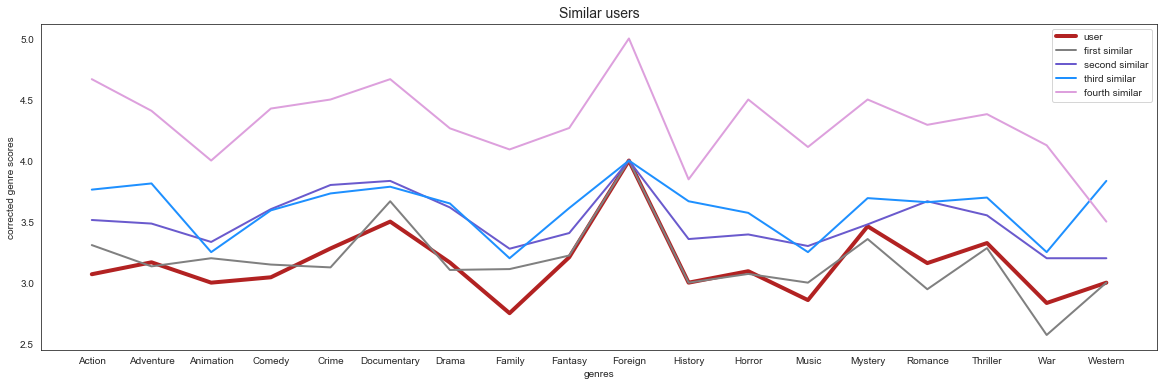

In [42]:
f, ax = plt.subplots(figsize=(20, 6))
_ = sns.set_style("white")
_ = sns.lineplot(data=df_similar_users['user'], color='firebrick', linewidth=4)
_ = sns.lineplot(data=df_similar_users['first similar'], color='grey', linewidth=2)
_ = sns.lineplot(data=df_similar_users['second similar'], color='slateblue', linewidth=2)
_ = sns.lineplot(data=df_similar_users['third similar'], color='dodgerblue', linewidth=2)
_ = sns.lineplot(data=df_similar_users['fourth similar'], color='plum', linewidth=2)
_ = plt.legend(['user', 'first similar', 'second similar', 'third similar', 'fourth similar'])
_ = plt.title('Similar users', fontsize=14)
_ = plt.xlabel('genres', fontsize=10)
_ = plt.ylabel('corrected genre scores', fontsize=10)

In [43]:
def predict_user_based(user_id, genre_id, feature_user_genre, metric = metric, k=k, verbose=True):
    """
    Adaptation of predict_userbased function availability in: 
    https://github.com/csaluja/JupyterNotebooks-Medium/blob/master/CF%20Recommendation%20System-Examples.ipynb?so
    """
    prediction=0
    similarities, indices = similar_users(user_id, feature_user_genre ,metric, k, verbose=False) #similar users based on cosine similarity
    mean_feature_user_genre = feature_user_genre.iloc[user_id,:].mean() #to adjust for zero based indexing
    sum_wt = np.sum(similarities)-1
    product=1
    wtd_sum = 0 
    
    for i in range(0, len(indices.flatten())):
        if indices.flatten()[i]+1 == user_id+1:
            continue;
        else: 
            feature_user_genre_diff = feature_user_genre.iloc[indices.flatten()[i],genre_id-1]-np.mean(feature_user_genre.iloc[indices.flatten()[i],:])
            product = feature_user_genre_diff * (similarities[i])
            wtd_sum = wtd_sum + product
    
    prediction = mean_feature_user_genre + (wtd_sum/sum_wt)
    if verbose:
        print ('\nFor user {} and item {}, the predicted score is {}'.format(user_id, genre_id-1, prediction))

    return prediction

Predicting scores for every genre of User 0:

In [44]:
user_test = 800
prediction = []
for i in range(18):
    p = predict_user_based(user_test, i+1, df_pivot, metric='cosine', k=4, verbose=False)
    prediction.append(p)
    
df_similar_users['prediction'] = prediction

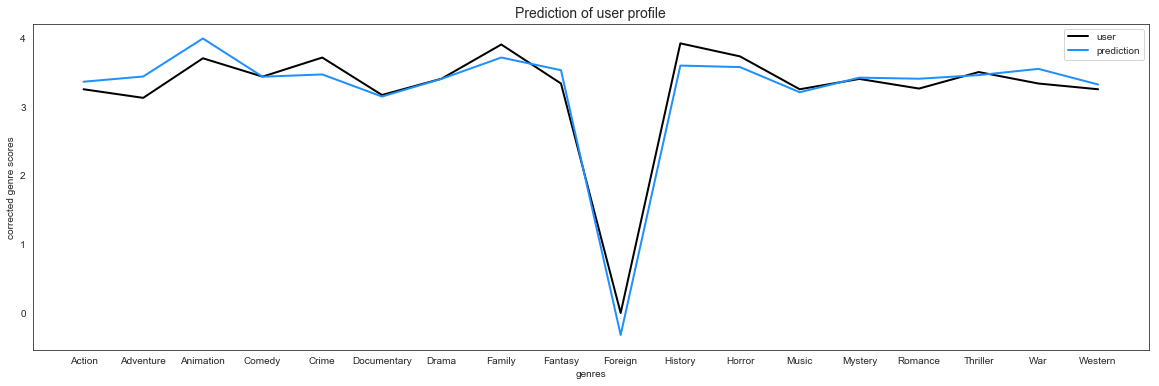

In [45]:
f, ax = plt.subplots(figsize=(20, 6))
_ = sns.set_style("white")
_ = sns.lineplot(data=df_pivot.iloc[user_test, :], color='black', linewidth=2)
_ = sns.lineplot(data=df_similar_users['prediction'], color='dodgerblue', linewidth=2)
_ = plt.legend(['user', 'prediction'])
_ = plt.title('Prediction of user profile', fontsize=14)
_ = plt.xlabel('genres', fontsize=10)
_ = plt.ylabel('corrected genre scores', fontsize=10)

In [46]:
from sklearn.metrics import mean_squared_error
mean_squared_error(df_pivot.iloc[user_test, :].values, df_similar_users['prediction'].values)

0.034962314885032236